<a href="https://colab.research.google.com/github/Zinnatullina-Regina/Cuda-Delane-Local-Triangul-Cpp/blob/main/CUDA_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
# Записываем исходный код в файл delaunay_cpu_visual.cpp
cat > delaunay_cpu_visual.cpp << 'EOF'
#include <iostream>
#include <vector>
#include <cstdlib>
#include <cmath>
#include <chrono>
#include <fstream>
#include <algorithm>

// Размеры подмножеств и максимальное число треугольников на подмножество
const int MAX_POINTS_PER_PART = 64;
const int MAX_TRIANGLES_PER_PART = 500;

// Структура для 3D точки (используем только x и y, z = 0)
struct Point3D {
    float x, y, z;
};

// Структура для треугольника (хранит индексы вершин)
struct TriangleIndices {
    int a, b, c;
};

// Структура для хранения треугольника с информацией о подмножестве (для цветовой разметки)
struct ColoredTriangle {
    TriangleIndices tri;
    int part;  // номер подмножества
};

// Функция для вычисления описанной окружности треугольника (A, B, C).
// Если треугольник вырожден (почти коллинеарен), возвращается false.
bool computeCircumcircle(const Point3D &A, const Point3D &B, const Point3D &C,
                         float &cx, float &cy, float &r2,
                         float epsilon = 1e-6f) {
    float d = 2.0f * (A.x * (B.y - C.y) +
                      B.x * (C.y - A.y) +
                      C.x * (A.y - B.y));
    if (fabs(d) < epsilon) {
        cx = cy = r2 = 0;
        return false;
    }
    float A_sq = A.x * A.x + A.y * A.y;
    float B_sq = B.x * B.x + B.y * B.y;
    float C_sq = C.x * C.x + C.y * C.y;
    cx = (A_sq * (B.y - C.y) +
          B_sq * (C.y - A.y) +
          C_sq * (A.y - B.y)) / d;
    cy = (A_sq * (C.x - B.x) +
          B_sq * (A.x - C.x) +
          C_sq * (B.x - A.x)) / d;
    float dx = A.x - cx;
    float dy = A.y - cy;
    r2 = dx * dx + dy * dy;
    return true;
}

// Функция для записи SVG-файла с визуализацией треугольников.
// Каждому подмножеству (partition) назначается свой цвет.
void writeSVG(const std::string &filename, const std::vector<Point3D>& points,
              const std::vector<ColoredTriangle>& triangles, int width = 500, int height = 500) {
    std::ofstream ofs(filename);
    if (!ofs) {
        std::cerr << "Ошибка открытия файла " << filename << " для записи SVG." << std::endl;
        return;
    }
    ofs << "<svg xmlns=\"http://www.w3.org/2000/svg\" width=\"" << width
        << "\" height=\"" << height << "\">" << std::endl;
    // Белый фон
    ofs << "<rect width=\"100%\" height=\"100%\" fill=\"white\"/>" << std::endl;

    // Набор цветов (будут циклически использоваться)
    std::vector<std::string> colors = {"red", "green", "blue", "orange", "purple", "cyan", "magenta", "brown"};

    // Функции для отображения координат (преобразование [-1,1] в пиксели)
    auto mapX = [width](float x) -> float {
        return (x + 1.0f) * width / 2.0f;
    };
    auto mapY = [height](float y) -> float {
        // Инвертируем координату y (SVG: y растёт вниз)
        return (1.0f - (y + 1.0f) / 2.0f) * height;
    };

    // Рисуем треугольники
    for (const auto& ct : triangles) {
        const TriangleIndices &tri = ct.tri;
        const std::string &color = colors[ct.part % colors.size()];
        float x1 = mapX(points[tri.a].x);
        float y1 = mapY(points[tri.a].y);
        float x2 = mapX(points[tri.b].x);
        float y2 = mapY(points[tri.b].y);
        float x3 = mapX(points[tri.c].x);
        float y3 = mapY(points[tri.c].y);
        ofs << "<polygon points=\""
            << x1 << "," << y1 << " "
            << x2 << "," << y2 << " "
            << x3 << "," << y3
            << "\" fill=\"none\" stroke=\"" << color << "\" stroke-width=\"1\" />" << std::endl;
    }
    // Рисуем точки
    for (const auto &p : points) {
        float cx = mapX(p.x);
        float cy = mapY(p.y);
        ofs << "<circle cx=\"" << cx << "\" cy=\"" << cy << "\" r=\"2\" fill=\"black\" />" << std::endl;
    }

    ofs << "</svg>" << std::endl;
    ofs.close();
}

int main() {
    // 1. Генерация случайного множества точек
    const int totalPoints = 256;
    std::vector<Point3D> points(totalPoints);
    for (int i = 0; i < totalPoints; i++) {
        points[i].x = static_cast<float>(rand()) / RAND_MAX * 2.0f - 1.0f;
        points[i].y = static_cast<float>(rand()) / RAND_MAX * 2.0f - 1.0f;
        points[i].z = 0.0f;
    }

    // 2. Разбивка точек на подмножества
    int pointsPerPart = MAX_POINTS_PER_PART;
    int numParts = (totalPoints + pointsPerPart - 1) / pointsPerPart;

    // Вектор для хранения треугольников с информацией о подмножестве
    std::vector<ColoredTriangle> allTriangles;

    auto t_start = std::chrono::high_resolution_clock::now();
    // 3. Вычисление локальной Делоне‑триангуляции для каждого подмножества
    for (int part = 0; part < numParts; part++) {
        int startIdx = part * pointsPerPart;
        int endIdx = std::min(startIdx + pointsPerPart, totalPoints);
        int P = endIdx - startIdx;
        if (P < 3) continue;
        int triangleCount = 0;
        // Перебор всех комбинаций трёх точек
        for (int i = 0; i < P - 2; i++) {
            for (int j = i + 1; j < P - 1; j++) {
                for (int k = j + 1; k < P; k++) {
                    float cx, cy, r2;
                    if (!computeCircumcircle(points[startIdx + i], points[startIdx + j], points[startIdx + k],
                                             cx, cy, r2))
                        continue;
                    bool isDelaunay = true;
                    // Проверяем все остальные точки подмножества
                    for (int m = 0; m < P; m++) {
                        if (m == i || m == j || m == k) continue;
                        float dx = points[startIdx + m].x - cx;
                        float dy = points[startIdx + m].y - cy;
                        float dist2 = dx * dx + dy * dy;
                        if (dist2 < r2 - 1e-6f) {
                            isDelaunay = false;
                            break;
                        }
                    }
                    if (isDelaunay) {
                        ColoredTriangle ct;
                        ct.tri.a = startIdx + i;
                        ct.tri.b = startIdx + j;
                        ct.tri.c = startIdx + k;
                        ct.part = part;
                        allTriangles.push_back(ct);
                        triangleCount++;
                        if (triangleCount >= MAX_TRIANGLES_PER_PART)
                            break;
                    }
                }
                if (triangleCount >= MAX_TRIANGLES_PER_PART)
                    break;
            }
            if (triangleCount >= MAX_TRIANGLES_PER_PART)
                break;
        }
        std::cout << "Подмножество " << part << " дало " << triangleCount << " треугольников." << std::endl;
    }
    auto t_end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double, std::milli> elapsed_ms = t_end - t_start;
    std::cout << "Время вычислений на CPU: " << elapsed_ms.count() << " ms" << std::endl;
    std::cout << "Всего треугольников: " << allTriangles.size() << std::endl;

    // 4. Сохранение результатов в SVG-файл
    writeSVG("triangulation_cpu.svg", points, allTriangles);
    std::cout << "SVG-файл 'triangulation_cpu.svg' создан." << std::endl;
    return 0;
}
EOF

# Компиляция и запуск
g++ delaunay_cpu_visual.cpp -o delaunay_cpu_visual -O2
./delaunay_cpu_visual


Подмножество 0 дало 118 треугольников.
Подмножество 1 дало 116 треугольников.
Подмножество 2 дало 115 треугольников.
Подмножество 3 дало 117 треугольников.
Подмножество 4 дало 115 треугольников.
Подмножество 5 дало 115 треугольников.
Подмножество 6 дало 117 треугольников.
Подмножество 7 дало 95 треугольников.
Время вычислений на CPU: 9.38518 ms
Всего треугольников: 908
SVG-файл 'triangulation_cpu.svg' создан.


In [ ]:
%%bash
# Записываем исходный код в файл delaunay_cuda_visual.cu
cat > delaunay_cuda_visual.cu << 'EOF'
// delaunay_cuda_visual.cu
//
// Параллельное вычисление локальной Делоне‑триангуляции на GPU с использованием
// разделяемой (shared) и константной (constant) памяти. Результаты сохраняются в SVG-файл.

#include <iostream>
#include <vector>
#include <cstdlib>
#include <cmath>
#include <algorithm>
#include <fstream>
#include <cuda_runtime.h>
#include <device_launch_parameters.h>

#define MAX_POINTS_PER_PART 64
#define MAX_TRIANGLES_PER_PART 500

// Макрос для проверки ошибок CUDA
#define CUDA_CHECK(call)                                               \
    do {                                                               \
        cudaError_t err = call;                                        \
        if (err != cudaSuccess) {                                      \
            std::cerr << "CUDA error in " << __FILE__ << "@" << __LINE__ \
                      << ": " << cudaGetErrorString(err) << std::endl; \
            exit(1);                                                   \
        }                                                              \
    } while (0)

// Объявление константной памяти для параметра-толерантности
__constant__ float c_epsilon;

// Структура для 3D точки (используем только x, y; z = 0)
struct Point3D {
    float x, y, z;
};

// Структура для треугольника (индексы вершин)
struct TriangleIndices {
    int a, b, c;
};

// Структура для хранения треугольника с информацией о подмножестве (для цветовой разметки)
struct ColoredTriangle {
    TriangleIndices tri;
    int part;
};

//
// __device__ функция для преобразования "плоского" номера комбинации в тройку индексов (i, j, k)
// для множества из P точек (всего C(P,3) комбинаций).
__device__ void flatIndexToTriple(int flat, int P, int &i, int &j, int &k) {
    int count = 0;
    for (i = 0; i < P - 2; i++) {
        int count_i = ((P - i - 1) * (P - i - 2)) / 2;
        if (flat < count + count_i)
            break;
        count += count_i;
    }
    int remainder = flat - count;
    for (j = i + 1; j < P - 1; j++) {
        int count_j = P - j - 1;
        if (remainder < count_j)
            break;
        remainder -= count_j;
    }
    k = j + 1 + remainder;
}

//
// __device__ функция для вычисления описанной окружности треугольника (A, B, C).
// Использует константную память c_epsilon для проверки вырожденности треугольника.
__device__ bool computeCircumcircle(const Point3D &A, const Point3D &B, const Point3D &C,
                                    float &cx, float &cy, float &r2) {
    float d = 2.0f * (A.x * (B.y - C.y) +
                      B.x * (C.y - A.y) +
                      C.x * (A.y - B.y));
    if (fabsf(d) < c_epsilon) {
        cx = cy = r2 = 0;
        return false;
    }
    float A_sq = A.x * A.x + A.y * A.y;
    float B_sq = B.x * B.x + B.y * B.y;
    float C_sq = C.x * C.x + C.y * C.y;
    cx = (A_sq * (B.y - C.y) +
          B_sq * (C.y - A.y) +
          C_sq * (A.y - B.y)) / d;
    cy = (A_sq * (C.x - B.x) +
          B_sq * (A.x - C.x) +
          C_sq * (B.x - A.x)) / d;
    float dx = A.x - cx;
    float dy = A.y - cy;
    r2 = dx * dx + dy * dy;
    return true;
}

//
// CUDA-ядро: Каждый блок обрабатывает одно подмножество точек (размером pointsPerPart).
// Точки копируются в shared memory, затем потоки перебирают комбинации трёх точек,
// проверяя условие Делоне‑триангуляции.
__global__ void delaunayKernel(Point3D *d_points, int totalPoints, int pointsPerPart,
                               TriangleIndices *d_localTriangles, int *d_counts) {
    int partId = blockIdx.x;
    int startIdx = partId * pointsPerPart;
    int endIdx = min(startIdx + pointsPerPart, totalPoints);
    int P = endIdx - startIdx;
    if (P < 3) return;

    __shared__ Point3D s_points[MAX_POINTS_PER_PART];
    for (int t = threadIdx.x; t < P; t += blockDim.x) {
        s_points[t] = d_points[startIdx + t];
    }
    __syncthreads();

    int totalComb = (P * (P - 1) * (P - 2)) / 6;
    for (int flat = threadIdx.x; flat < totalComb; flat += blockDim.x) {
        int i, j, k;
        flatIndexToTriple(flat, P, i, j, k);
        float cx, cy, r2;
        if (!computeCircumcircle(s_points[i], s_points[j], s_points[k], cx, cy, r2))
            continue;
        bool isDelaunay = true;
        for (int m = 0; m < P; m++) {
            if (m == i || m == j || m == k) continue;
            float dx = s_points[m].x - cx;
            float dy = s_points[m].y - cy;
            float dist2 = dx * dx + dy * dy;
            if (dist2 < r2 - c_epsilon) {
                isDelaunay = false;
                break;
            }
        }
        if (isDelaunay) {
            int index = atomicAdd(&d_counts[partId], 1);
            if (index < MAX_TRIANGLES_PER_PART) {
                d_localTriangles[partId * MAX_TRIANGLES_PER_PART + index].a = startIdx + i;
                d_localTriangles[partId * MAX_TRIANGLES_PER_PART + index].b = startIdx + j;
                d_localTriangles[partId * MAX_TRIANGLES_PER_PART + index].c = startIdx + k;
            }
        }
    }
}

// Функция для записи SVG-файла (аналогична CPU‑версии)
void writeSVG(const std::string &filename, const std::vector<Point3D>& points,
              const std::vector<ColoredTriangle>& triangles, int width = 500, int height = 500) {
    std::ofstream ofs(filename);
    if (!ofs) {
        std::cerr << "Ошибка открытия файла " << filename << " для записи SVG." << std::endl;
        return;
    }
    ofs << "<svg xmlns=\"http://www.w3.org/2000/svg\" width=\"" << width
        << "\" height=\"" << height << "\">" << std::endl;
    ofs << "<rect width=\"100%\" height=\"100%\" fill=\"white\"/>" << std::endl;
    std::vector<std::string> colors = {"red", "green", "blue", "orange", "purple", "cyan", "magenta", "brown"};
    auto mapX = [width](float x) -> float {
        return (x + 1.0f) * width / 2.0f;
    };
    auto mapY = [height](float y) -> float {
        return (1.0f - (y + 1.0f) / 2.0f) * height;
    };
    for (const auto &ct : triangles) {
        const TriangleIndices &tri = ct.tri;
        const std::string &color = colors[ct.part % colors.size()];
        float x1 = mapX(points[tri.a].x);
        float y1 = mapY(points[tri.a].y);
        float x2 = mapX(points[tri.b].x);
        float y2 = mapY(points[tri.b].y);
        float x3 = mapX(points[tri.c].x);
        float y3 = mapY(points[tri.c].y);
        ofs << "<polygon points=\""
            << x1 << "," << y1 << " "
            << x2 << "," << y2 << " "
            << x3 << "," << y3
            << "\" fill=\"none\" stroke=\"" << color << "\" stroke-width=\"1\" />" << std::endl;
    }
    for (const auto &p : points) {
        float cx = mapX(p.x);
        float cy = mapY(p.y);
        ofs << "<circle cx=\"" << cx << "\" cy=\"" << cy << "\" r=\"2\" fill=\"black\" />" << std::endl;
    }
    ofs << "</svg>" << std::endl;
    ofs.close();
}

int main() {
    // 1. Инициализация константного параметра (epsilon)
    float h_epsilon = 1e-6f;
    CUDA_CHECK(cudaMemcpyToSymbol(c_epsilon, &h_epsilon, sizeof(float)));

    // 2. Генерация случайного множества точек
    const int totalPoints = 256;
    std::vector<Point3D> h_points(totalPoints);
    for (int i = 0; i < totalPoints; i++) {
        h_points[i].x = static_cast<float>(rand()) / RAND_MAX * 2.0f - 1.0f;
        h_points[i].y = static_cast<float>(rand()) / RAND_MAX * 2.0f - 1.0f;
        h_points[i].z = 0.0f;
    }

    // 3. Разбивка точек на подмножества
    const int pointsPerPart = MAX_POINTS_PER_PART;
    int numParts = (totalPoints + pointsPerPart - 1) / pointsPerPart;

    // Выделяем память на GPU для точек
    Point3D *d_points = nullptr;
    CUDA_CHECK(cudaMalloc(&d_points, totalPoints * sizeof(Point3D)));
    CUDA_CHECK(cudaMemcpy(d_points, h_points.data(), totalPoints * sizeof(Point3D),
                          cudaMemcpyHostToDevice));

    // Выделяем память для локальных триангуляций и счётчиков
    TriangleIndices *d_localTriangles = nullptr;
    CUDA_CHECK(cudaMalloc(&d_localTriangles, numParts * MAX_TRIANGLES_PER_PART * sizeof(TriangleIndices)));
    int *d_counts = nullptr;
    CUDA_CHECK(cudaMalloc(&d_counts, numParts * sizeof(int)));
    CUDA_CHECK(cudaMemset(d_counts, 0, numParts * sizeof(int)));

    // 4. Запуск CUDA‑ядра (по одному блоку на подмножество, 256 потоков)
    int threadsPerBlock = 256;
    cudaEvent_t start, stop;
    CUDA_CHECK(cudaEventCreate(&start));
    CUDA_CHECK(cudaEventCreate(&stop));
    CUDA_CHECK(cudaEventRecord(start));

    delaunayKernel<<<numParts, threadsPerBlock>>>(d_points, totalPoints, pointsPerPart,
                                                  d_localTriangles, d_counts);
    CUDA_CHECK(cudaEventRecord(stop));
    CUDA_CHECK(cudaEventSynchronize(stop));
    float milliseconds = 0;
    CUDA_CHECK(cudaEventElapsedTime(&milliseconds, start, stop));
    CUDA_CHECK(cudaDeviceSynchronize());

    // 5. Копирование результатов с GPU
    std::vector<int> h_counts(numParts);
    CUDA_CHECK(cudaMemcpy(h_counts.data(), d_counts, numParts * sizeof(int), cudaMemcpyDeviceToHost));

    std::vector<TriangleIndices> h_localTriangles(numParts * MAX_TRIANGLES_PER_PART);
    CUDA_CHECK(cudaMemcpy(h_localTriangles.data(), d_localTriangles,
                          numParts * MAX_TRIANGLES_PER_PART * sizeof(TriangleIndices),
                          cudaMemcpyDeviceToHost));

    // Собираем результаты в ColoredTriangle
    std::vector<ColoredTriangle> allTriangles;
    int totalTriangles = 0;
    for (int part = 0; part < numParts; part++) {
        totalTriangles += h_counts[part];
        std::cout << "Подмножество " << part << " дало " << h_counts[part] << " треугольников." << std::endl;
        for (int t = 0; t < h_counts[part] && t < MAX_TRIANGLES_PER_PART; t++) {
            ColoredTriangle ct;
            ct.tri = h_localTriangles[part * MAX_TRIANGLES_PER_PART + t];
            ct.part = part;
            allTriangles.push_back(ct);
        }
    }
    std::cout << "Всего треугольников (локальные триангуляции): " << totalTriangles << std::endl;
    std::cout << "Время выполнения CUDA-ядра: " << milliseconds << " ms" << std::endl;

    // 6. Сохранение результатов в SVG-файл
    writeSVG("triangulation_cuda.svg", h_points, allTriangles);
    std::cout << "SVG-файл 'triangulation_cuda.svg' создан." << std::endl;

    // Освобождение памяти
    CUDA_CHECK(cudaFree(d_points));
    CUDA_CHECK(cudaFree(d_localTriangles));
    CUDA_CHECK(cudaFree(d_counts));
    CUDA_CHECK(cudaEventDestroy(start));
    CUDA_CHECK(cudaEventDestroy(stop));

    return 0;
}
EOF

# Перекомпиляция CUDA-версии с указанием архитектуры и разрешением неподдерживаемого компилятора

nvcc delaunay_cuda_visual.cu -o delaunay_cuda_visual -gencode arch=compute_70,code=sm_70
./delaunay_cuda_visual



Подмножество 0 дало 118 треугольников.
Подмножество 1 дало 116 треугольников.
Подмножество 2 дало 115 треугольников.
Подмножество 3 дало 117 треугольников.
Подмножество 4 дало 115 треугольников.
Подмножество 5 дало 115 треугольников.
Подмножество 6 дало 117 треугольников.
Подмножество 7 дало 95 треугольников.
Всего треугольников (локальные триангуляции): 908
Время выполнения CUDA-ядра: 0.899072 ms
SVG-файл 'triangulation_cuda.svg' создан.


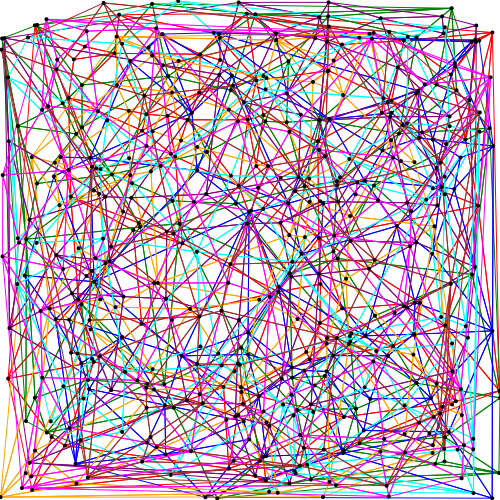

In [ ]:
from IPython.display import SVG, display
display(SVG("triangulation_cpu.svg"))


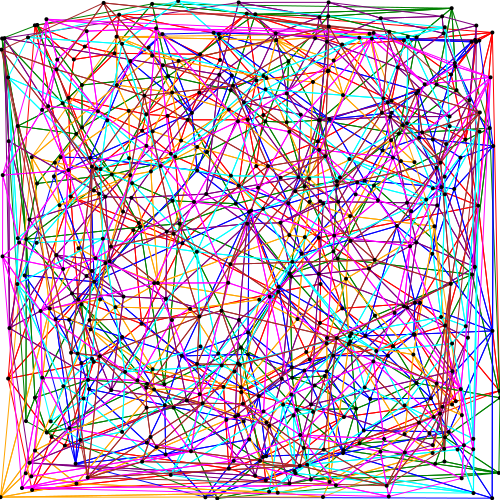

In [ ]:
from IPython.display import SVG, display
display(SVG("triangulation_cuda.svg"))


In [ ]:
!cat /proc/cpuinfo


processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.148
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmi

In [ ]:
%%bash
# Сохранение исходного кода CPU‑версии в файл delaunay_cpu_perf.cpp
cat > delaunay_cpu_perf.cpp << 'EOF'
#include <iostream>
#include <vector>
#include <cstdlib>
#include <cmath>
#include <chrono>
#include <fstream>
#include <algorithm>

const int MAX_POINTS_PER_PART = 64;
const int MAX_TRIANGLES_PER_PART = 500;

struct Point3D {
    float x, y, z;
};

struct TriangleIndices {
    int a, b, c;
};

bool computeCircumcircle(const Point3D &A, const Point3D &B, const Point3D &C,
                         float &cx, float &cy, float &r2, float epsilon = 1e-6f) {
    float d = 2.0f * (A.x * (B.y - C.y) +
                      B.x * (C.y - A.y) +
                      C.x * (A.y - B.y));
    if (fabs(d) < epsilon) {
        cx = cy = r2 = 0;
        return false;
    }
    float A_sq = A.x * A.x + A.y * A.y;
    float B_sq = B.x * B.x + B.y * B.y;
    float C_sq = C.x * C.x + C.y * C.y;
    cx = (A_sq * (B.y - C.y) +
          B_sq * (C.y - A.y) +
          C_sq * (A.y - B.y)) / d;
    cy = (A_sq * (C.x - B.x) +
          B_sq * (A.x - C.x) +
          C_sq * (B.x - A.x)) / d;
    float dx = A.x - cx;
    float dy = A.y - cy;
    r2 = dx * dx + dy * dy;
    return true;
}

int main() {
    std::ofstream csv("cpu_performance.csv");
    csv << "totalPoints,pointsPerPart,CPU_time_ms\n";

    // Перебор параметров:
    // totalPoints: от 500 до 5000 с шагом 500
    // pointsPerPart: 32, 64, 128
    for (int totalPoints = 500; totalPoints <= 5000; totalPoints += 500) {
        for (int pointsPerPart : {32, 64, 128}) {
            // Генерация случайных точек
            std::vector<Point3D> points(totalPoints);
            for (int i = 0; i < totalPoints; i++) {
                points[i].x = static_cast<float>(rand()) / RAND_MAX * 2.0f - 1.0f;
                points[i].y = static_cast<float>(rand()) / RAND_MAX * 2.0f - 1.0f;
                points[i].z = 0.0f;
            }

            int numParts = (totalPoints + pointsPerPart - 1) / pointsPerPart;
            int totalTriangles = 0;

            auto t_start = std::chrono::high_resolution_clock::now();
            // Для каждого подмножества
            for (int part = 0; part < numParts; part++) {
                int startIdx = part * pointsPerPart;
                int endIdx = std::min(startIdx + pointsPerPart, totalPoints);
                int P = endIdx - startIdx;
                if (P < 3) continue;
                int triangleCount = 0;
                // Перебор всех комбинаций трёх точек
                for (int i = 0; i < P - 2; i++) {
                    for (int j = i + 1; j < P - 1; j++) {
                        for (int k = j + 1; k < P; k++) {
                            float cx, cy, r2;
                            if (!computeCircumcircle(points[startIdx + i], points[startIdx + j], points[startIdx + k],
                                                     cx, cy, r2))
                                continue;
                            bool isDelaunay = true;
                            for (int m = 0; m < P; m++) {
                                if (m == i || m == j || m == k)
                                    continue;
                                float dx = points[startIdx + m].x - cx;
                                float dy = points[startIdx + m].y - cy;
                                float dist2 = dx * dx + dy * dy;
                                if (dist2 < r2 - 1e-6f) {
                                    isDelaunay = false;
                                    break;
                                }
                            }
                            if (isDelaunay) {
                                triangleCount++;
                                if (triangleCount >= MAX_TRIANGLES_PER_PART)
                                    break;
                            }
                        }
                        if (triangleCount >= MAX_TRIANGLES_PER_PART)
                            break;
                    }
                    if (triangleCount >= MAX_TRIANGLES_PER_PART)
                        break;
                }
                totalTriangles += triangleCount;
            }
            auto t_end = std::chrono::high_resolution_clock::now();
            double cpu_time = std::chrono::duration<double, std::milli>(t_end - t_start).count();
            csv << totalPoints << "," << pointsPerPart << "," << cpu_time << "\n";
            std::cout << "CPU: totalPoints = " << totalPoints
                      << ", pointsPerPart = " << pointsPerPart
                      << ", time = " << cpu_time << " ms, triangles = " << totalTriangles << std::endl;
        }
    }
    csv.close();
    return 0;
}
EOF

# Компиляция и запуск CPU-версии
g++ delaunay_cpu_perf.cpp -o delaunay_cpu_perf -O2
./delaunay_cpu_perf


In [ ]:
%%bash
# Сохранение исходного кода CUDA‑версии в файл delaunay_cuda_perf.cu
cat > delaunay_cuda_perf.cu << 'EOF'
// delaunay_cuda_perf.cu
// Параллельный расчёт локальной Делоне‑триангуляции на GPU с циклическим перебором параметров

#include <iostream>
#include <vector>
#include <cstdlib>
#include <cmath>
#include <algorithm>
#include <fstream>
#include <cuda_runtime.h>
#include <device_launch_parameters.h>

#define MAX_POINTS_PER_PART 64
#define MAX_TRIANGLES_PER_PART 500

// Макрос для проверки ошибок CUDA
#define CUDA_CHECK(call)                                               \
    do {                                                               \
        cudaError_t err = call;                                        \
        if (err != cudaSuccess) {                                      \
            std::cerr << "CUDA error in " << __FILE__ << "@" << __LINE__ \
                      << ": " << cudaGetErrorString(err) << std::endl; \
            exit(1);                                                   \
        }                                                              \
    } while (0)

// Инициализация константной памяти
__constant__ float c_epsilon;

struct Point3D {
    float x, y, z;
};

struct TriangleIndices {
    int a, b, c;
};

// Преобразование «плоского» индекса в тройку индексов (i,j,k) для C(P,3)
__device__ void flatIndexToTriple(int flat, int P, int &i, int &j, int &k) {
    int count = 0;
    for (i = 0; i < P - 2; i++) {
        int count_i = ((P - i - 1) * (P - i - 2)) / 2;
        if (flat < count + count_i)
            break;
        count += count_i;
    }
    int remainder = flat - count;
    for (j = i + 1; j < P - 1; j++) {
        int count_j = P - j - 1;
        if (remainder < count_j)
            break;
        remainder -= count_j;
    }
    k = j + 1 + remainder;
}

// Вычисление описанной окружности треугольника (A, B, C)
__device__ bool computeCircumcircle(const Point3D &A, const Point3D &B, const Point3D &C,
                                    float &cx, float &cy, float &r2) {
    float d = 2.0f * (A.x * (B.y - C.y) +
                      B.x * (C.y - A.y) +
                      C.x * (A.y - B.y));
    if (fabsf(d) < c_epsilon) {
        cx = cy = r2 = 0;
        return false;
    }
    float A_sq = A.x * A.x + A.y * A.y;
    float B_sq = B.x * B.x + B.y * B.y;
    float C_sq = C.x * C.x + C.y * C.y;
    cx = (A_sq * (B.y - C.y) +
          B_sq * (C.y - A.y) +
          C_sq * (A.y - B.y)) / d;
    cy = (A_sq * (C.x - B.x) +
          B_sq * (A.x - C.x) +
          C_sq * (B.x - A.x)) / d;
    float dx = A.x - cx;
    float dy = A.y - cy;
    r2 = dx * dx + dy * dy;
    return true;
}

// CUDA‑ядро: каждый блок обрабатывает одно подмножество точек
__global__ void delaunayKernel(Point3D *d_points, int totalPoints, int pointsPerPart,
                               TriangleIndices *d_localTriangles, int *d_counts) {
    int partId = blockIdx.x;
    int startIdx = partId * pointsPerPart;
    int endIdx = min(startIdx + pointsPerPart, totalPoints);
    int P = endIdx - startIdx;
    if (P < 3) return;

    __shared__ Point3D s_points[MAX_POINTS_PER_PART];
    for (int t = threadIdx.x; t < P; t += blockDim.x) {
        s_points[t] = d_points[startIdx + t];
    }
    __syncthreads();

    int totalComb = (P * (P - 1) * (P - 2)) / 6;
    for (int flat = threadIdx.x; flat < totalComb; flat += blockDim.x) {
        int i, j, k;
        flatIndexToTriple(flat, P, i, j, k);
        float cx, cy, r2;
        if (!computeCircumcircle(s_points[i], s_points[j], s_points[k], cx, cy, r2))
            continue;
        bool isDelaunay = true;
        for (int m = 0; m < P; m++) {
            if (m == i || m == j || m == k) continue;
            float dx = s_points[m].x - cx;
            float dy = s_points[m].y - cy;
            float dist2 = dx * dx + dy * dy;
            if (dist2 < r2 - c_epsilon) {
                isDelaunay = false;
                break;
            }
        }
        if (isDelaunay) {
            int index = atomicAdd(&d_counts[partId], 1);
            if (index < MAX_TRIANGLES_PER_PART) {
                d_localTriangles[partId * MAX_TRIANGLES_PER_PART + index].a = startIdx + i;
                d_localTriangles[partId * MAX_TRIANGLES_PER_PART + index].b = startIdx + j;
                d_localTriangles[partId * MAX_TRIANGLES_PER_PART + index].c = startIdx + k;
            }
        }
    }
}

int main() {
    std::ofstream csv("gpu_performance.csv");
    csv << "totalPoints,pointsPerPart,GPU_time_ms\n";

    float h_epsilon = 1e-6f;
    CUDA_CHECK(cudaMemcpyToSymbol(c_epsilon, &h_epsilon, sizeof(float)));

    // Перебор параметров: totalPoints от 500 до 5000, pointsPerPart: 32, 64, 128
    for (int totalPoints = 500; totalPoints <= 5000; totalPoints += 500) {
        for (int pointsPerPart : {32, 64, 128}) {
            int numParts = (totalPoints + pointsPerPart - 1) / pointsPerPart;
            std::vector<Point3D> h_points(totalPoints);
            for (int i = 0; i < totalPoints; i++) {
                h_points[i].x = static_cast<float>(rand()) / RAND_MAX * 2.0f - 1.0f;
                h_points[i].y = static_cast<float>(rand()) / RAND_MAX * 2.0f - 1.0f;
                h_points[i].z = 0.0f;
            }

            Point3D *d_points = nullptr;
            CUDA_CHECK(cudaMalloc(&d_points, totalPoints * sizeof(Point3D)));
            CUDA_CHECK(cudaMemcpy(d_points, h_points.data(), totalPoints * sizeof(Point3D),
                                  cudaMemcpyHostToDevice));

            TriangleIndices *d_localTriangles = nullptr;
            CUDA_CHECK(cudaMalloc(&d_localTriangles, numParts * MAX_TRIANGLES_PER_PART * sizeof(TriangleIndices)));
            int *d_counts = nullptr;
            CUDA_CHECK(cudaMalloc(&d_counts, numParts * sizeof(int)));
            CUDA_CHECK(cudaMemset(d_counts, 0, numParts * sizeof(int)));

            int threadsPerBlock = 256;
            cudaEvent_t start, stop;
            CUDA_CHECK(cudaEventCreate(&start));
            CUDA_CHECK(cudaEventCreate(&stop));
            CUDA_CHECK(cudaEventRecord(start));

            delaunayKernel<<<numParts, threadsPerBlock>>>(d_points, totalPoints, pointsPerPart,
                                                          d_localTriangles, d_counts);
            CUDA_CHECK(cudaEventRecord(stop));
            CUDA_CHECK(cudaEventSynchronize(stop));
            float gpu_time = 0;
            CUDA_CHECK(cudaEventElapsedTime(&gpu_time, start, stop));
            CUDA_CHECK(cudaDeviceSynchronize());

            CUDA_CHECK(cudaEventDestroy(start));
            CUDA_CHECK(cudaEventDestroy(stop));

            // Освобождение памяти на GPU
            CUDA_CHECK(cudaFree(d_points));
            CUDA_CHECK(cudaFree(d_localTriangles));
            CUDA_CHECK(cudaFree(d_counts));

            csv << totalPoints << "," << pointsPerPart << "," << gpu_time << "\n";
            std::cout << "GPU: totalPoints = " << totalPoints
                      << ", pointsPerPart = " << pointsPerPart
                      << ", time = " << gpu_time << " ms" << std::endl;
        }
    }
    csv.close();
    return 0;
}
EOF

# Компиляция и запуск CUDA-версии
nvcc delaunay_cuda_perf.cu -o delaunay_cuda_perf -gencode arch=compute_70,code=sm_70
./delaunay_cuda_perf
